In [107]:
from Functions.data_analysis import *
from Functions.database import getTransaction, getAccount
from Functions.variables import typeMapping
import numpy as np
from scipy.stats import linregress
import pandas as pd
from matplotlib import pyplot as plt

plt.style.use('fivethirtyeight')

In [108]:
myAcc = getAccount("atlasss")
myAcc.summary()

df = getTransaction(myAcc)

       Username: atlasss
       Password: 1912766d6ba0e50e8b1bacfb51207e83b95b7ac0cd8ce15307cdf4965e7e3f6c
   Date Created: 2024-09-04 04:30:17
   Date Updated: 2024-09-04 04:30:17
        Balance: 10000000


In [109]:
class enrichedData:
    def __init__(self, old_data: pd.DataFrame, data: pd.DataFrame, figsize: tuple[int, int] = (10, 5)) -> None:
        self.old_data = old_data
        self.data = data
        self.figsize = figsize
        
    def plotAll(self, RANGE1: str, RANGE2: str, displacement: tuple[int, ...]):
        _, ax = plt.subplots(figsize=self.figsize)

        if RANGE1 != "YEAR":
            last_data = self.data['Features', RANGE2].iloc[-1] - displacement
            curData = self.data[self.data['Features', RANGE2] == last_data]
            curData = curData.groupby(self.data['Features'][RANGE1]).sum()

            ax.text(0.5, 1.01, f"{RANGE2.title()} {last_data}", ha='center', va='center', transform=ax.transAxes, fontsize=15)
        else:
            curData = self.data.groupby(self.data['Features']['YEAR']).sum()
            last_data = curData.index[-1]

            ax.text(0.5, 1.01, f"All Year", ha='center', va='center', transform=ax.transAxes, fontsize=15)


        plt.xlabel(RANGE1.title())
        plt.ylabel("Rp.")
        plt.title("Complete Plot", pad=20)
    
        curData['Expenses']['TOTAL'].cumsum().plot(ax=ax, label='Cumulative Expenses', alpha=0.6)
        curData['Revenue']['TOTAL'].cumsum().plot(ax=ax, label='Cumulative Revenue', alpha=0.6)
        curData['TOTAL'].cumsum().plot(ax=ax, label='Budget', alpha=0.6)
    
        plt.legend()
        plt.show()
    
    def plotCategory(self, cat:int):
        _, ax = plt.subplots(figsize=self.figsize)

        all_types = [0, 1, 2, 3, 4, 5, 10, 11, 12, 13]

        byType = self.old_data.groupby('TYPE')['VALUE'].sum().reset_index()
        byType = byType.set_index('TYPE').reindex(all_types, fill_value=0).reset_index()
        byType['TYPE_LABEL'] = byType['TYPE'].map(typeMapping)
        byType = byType.sort_values("VALUE", ascending=False)

        colors = ["red" if type_val < 10 else "green" for type_val in byType['TYPE']]
        plt.bar(byType['TYPE_LABEL'], byType['VALUE'], color=colors)

        plt.xlabel('Type')
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Rp.')
        plt.title('Expenses by Type')
        ax.text(0.5, 1.01, f"All Year", ha='center', va='center', transform=ax.transAxes, fontsize=15)
        
        plt.show()
        

In [110]:
def enrichData(df: pd.DataFrame) -> enrichedData:
  old_data = df.copy()
  def WoM(dt):
    """ Returns the week of the month for the specified date. """
    first_day = dt.replace(day=1)
    dom = dt.day
    adjusted_dom = dom + first_day.weekday()
    
    return int(np.ceil(adjusted_dom / 7.0))

  df['UPDATED_AT'] = pd.to_datetime(df['UPDATED_AT'])
  df = df.drop(columns=['CREATED_AT', 'TRANSACTION_ID', 'ITEM', 'USERNAME']).set_index('UPDATED_AT').sort_index()
  
  
  expenses = pd.concat([
    df[(df['CATEGORY'] == 0) & (df['TYPE'] == i)]
    .drop(columns=['CATEGORY', 'TYPE'])
    .resample('D')
    .sum()
    .rename(columns={'VALUE': f'{i}'})
    for i in df[df['CATEGORY'] == 0]['TYPE'].unique()
  ], axis=1)

  
  revenue = pd.concat([
    df[(df['CATEGORY'] == 1) & (df['TYPE'] == i)]
    .drop(columns=['CATEGORY', 'TYPE'])
    .resample('D')
    .sum()
    .rename(columns={'VALUE': f'{i}'})
    for i in df[df['CATEGORY'] == 1]['TYPE'].unique()
  ], axis=1)

  expenses = expenses.reindex(sorted(expenses.columns, key=lambda x: int(x)), axis=1)
  revenue = revenue.reindex(sorted(revenue.columns, key=lambda x: int(x)), axis=1)


  expenses.columns = pd.MultiIndex.from_product([['Expenses'], expenses.columns])
  revenue.columns = pd.MultiIndex.from_product([['Revenue'], revenue.columns])

  expenses[('Expenses', 'TOTAL')] = expenses.sum(axis=1)
  revenue[('Revenue', 'TOTAL')] = revenue.sum(axis=1)


  features = pd.DataFrame(index=expenses.index.union(revenue.index))
  features[("Features", "DoW")] = features.index.day_of_week
  features[("Features", "DoM")] = features.index.day
  features[("Features", "WoM")] = features.index.map(WoM)
  features[("Features", "DAY")] = features.index.day_of_year
  features[("Features", "WEEK")] = features.index.isocalendar().week
  features[("Features", "QUARTER")] = features.index.quarter
  features[("Features", "MONTH")] = features.index.month
  features[("Features", "YEAR")] = features.index.year

  DATA = pd.concat([expenses, revenue, features], axis=1).fillna(0)
  
  DATA.index.name = "DATE"
  DATA['TOTAL'] = DATA['Revenue', 'TOTAL'] - DATA['Expenses', 'TOTAL']

  return enrichedData(old_data, DATA)


In [111]:
myData = enrichData(df)

all_types = [0, 1, 2, 3, 4, 5, 10, 11, 12, 13]

summed_df = myData.old_data.groupby('TYPE')['VALUE'].sum().reset_index()
summed_df = summed_df.set_index('TYPE').reindex(all_types, fill_value=0).reset_index()
summed_df   

,TYPE,VALUE
0,0,42615000
1,1,6900000
2,2,3900000
3,3,1900000
4,4,0
5,5,100000000
6,10,144000000
7,11,32000000
8,12,12000000
9,13,3000000


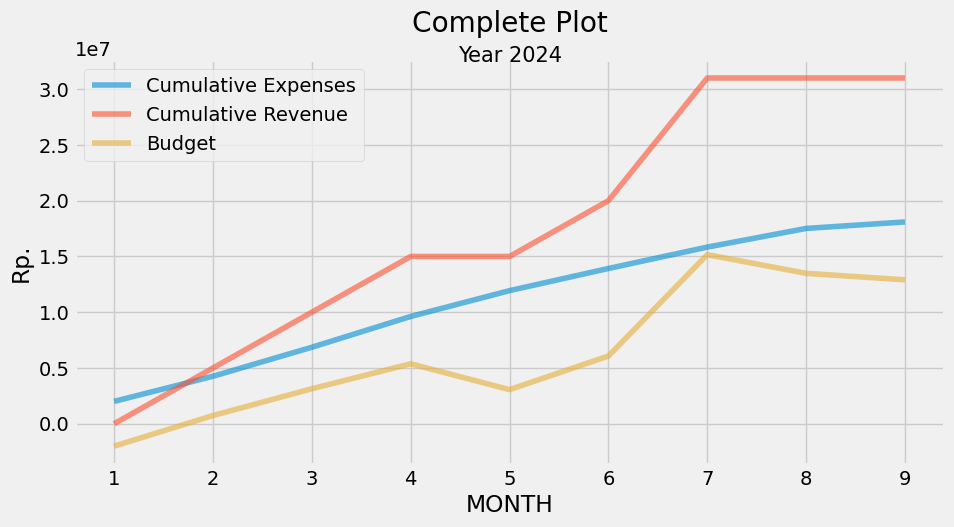

In [112]:
myData.plotAll("MONTH", "YEAR", (0))

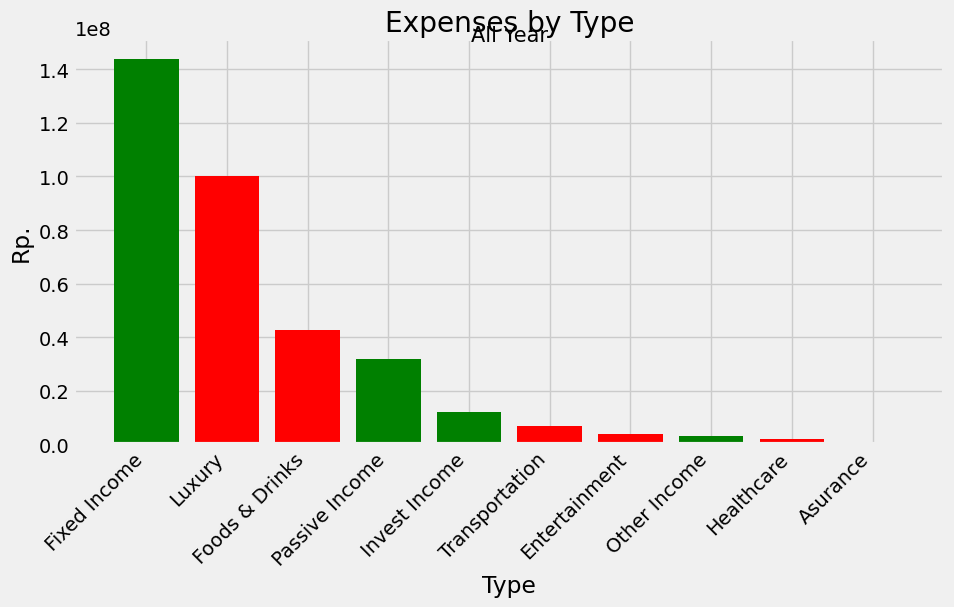

In [113]:
myData.plotCategory(0)